# Aim

Windowing out a specific width around a PSD is ineffective and can be improved, so this notebook is designated for testing those improvements.

In [1]:
from observer import *
import numpy as np
from scipy import signal

In [2]:
N_vib_app = 5

def make_vibe_params(N=N_vib_app):
    vib_amps = np.random.uniform(low=0.1, high=1, size=N)  # milliarcseconds
    vib_freqs = np.random.uniform(low=f_1, high=f_2, size=N)  # Hz
    vib_damping = np.random.uniform(low=1e-5, high=1e-2, size=N)  # unitless
    vib_phase = np.random.uniform(low=0.0, high=2 * np.pi, size=N)  # radians
    return vib_amps, vib_freqs, vib_damping, vib_phase


def make_vibe_data(vib_params=None, N=N_vib_app):
    # adjusted so that each 'pos' mode is the solution to the DE
    # x'' + 2k w0 x' + w0^2 x = 0 with w0 = 2pi*f/sqrt(1-k^2) 
    # (chosen so that vib_freqs matches up with the PSD freq)
    if vib_params is None:
        vib_amps, vib_freqs, vib_damping, vib_phase = make_vibe_params(N)
    else:
        vib_amps, vib_freqs, vib_damping, vib_phase = vib_params
        N = vib_freqs.size

    pos = sum([vib_amps[i] * np.cos(2 * np.pi * vib_freqs[i] * times - vib_phase[i])
               * np.exp(-(vib_damping[i]/(1 - vib_damping[i]**2)) * 2 * np.pi * vib_freqs[i] * times) 
               for i in range(N)])

    return pos

params = make_vibe_params()
truth = make_vibe_data(params)
measurements = truth + np.random.normal(0, 0.06, truth.size)
psd = get_psd(truth)
psd_noisy = get_psd(measurements)

In [7]:
def noise_filter(psd):
    # takes in a PSD.
    # returns a cleaned PSD with measurement noise hopefully removed.
    ind = np.argmax(freqs > f_w)
    assert ind != 0, "didn't find a high enough frequency"
    avg_measurement_power = np.mean(psd[ind:])
    measurement_noise_recovered = np.sqrt(f_sampling * avg_measurement_power)
    psd -= avg_measurement_power

    # this subtraction is problematic because it goes negative, so quick correction here.
    # Want a better way of doing this.

    for i, p in enumerate(psd):
        if p < 0:
            psd[i] = energy_cutoff

    # ad hoc low-pass filter
    ind_cutoff = np.argmax(freqs > f_2)
    psd[ind_cutoff:] = energy_cutoff * np.ones(len(psd) - ind_cutoff)  # or all zero?
    return psd

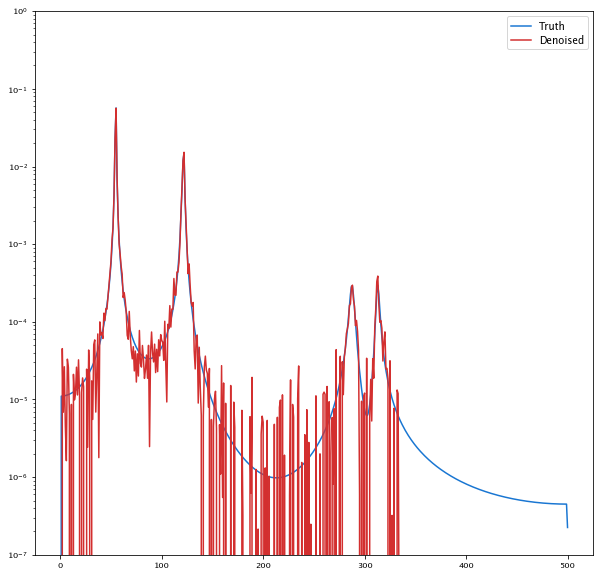

In [8]:
plt.figure(figsize=(10,10))
plt.semilogy(freqs, psd, label="Truth")
#plt.semilogy(freqs, psd_noisy, label="Noisy")
plt.semilogy(freqs, noise_filter(psd_noisy), label="Denoised")
plt.semilogy(freqs, )
plt.ylim(1e-7, 1)
plt.legend()